In [3]:
import pandas as pd
import re
import string

def preprocess_ag_news(file_path):
    # 1. Load data - skipping the header row
    df = pd.read_csv(file_path, header=0, names=['label', 'title', 'description'], engine='python')

    # 2. Map numeric labels to names for better visualization
    label_map = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
    df['class_name'] = df['label'].map(label_map)

    # 3. Combine Title and Description
    df['text'] = df['title'] + " " + df['description']

    def clean_text(text):
        # Lowercase
        text = text.lower()
        # Remove backslash escapes like \n or \b
        text = re.sub(r'\\[nb]', ' ', text)
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text

    print(f"Cleaning {file_path}...")
    df['text'] = df['text'].apply(clean_text)

    # Keep only what is necessary for the models
    return df[['text', 'label', 'class_name']]

# EXECUTION
train_cleaned = preprocess_ag_news('/content/train.csv')
test_cleaned = preprocess_ag_news('/content/test.csv')

# Save to shared CSVs
train_cleaned.to_csv('ag_news_train_cleaned.csv', index=False)
test_cleaned.to_csv('ag_news_test_cleaned.csv', index=False)

print("\nSample Output:")
print(train_cleaned.head())
print("\nClass Distribution:")
print(train_cleaned['class_name'].value_counts())

Cleaning /content/train.csv...
Cleaning /content/test.csv...

Sample Output:
                                                text  label class_name
0  wall st bears claw back into the black reuters...      3   Business
1  carlyle looks toward commercial aerospace reut...      3   Business
2  oil and economy cloud stocks outlook reuters r...      3   Business
3  iraq halts oil exports from main southern pipe...      3   Business
4  oil prices soar to alltime record posing new m...      3   Business

Class Distribution:
class_name
World       20839
Sci/Tech    20532
Sports      20272
Business    20210
Name: count, dtype: int64


In [4]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 66.6 MB/s eta 0:00:00


In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout,Input
from tensorflow.keras.optimizers import Adam

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

from gensim.models import Word2Vec, FastText
import matplotlib.pyplot as plt
import seaborn as sns

Helper function: Vanilla RNN model

Load and prepare the data

In [6]:
# Load the cleaned data
train_df = pd.read_csv('ag_news_train_cleaned.csv')
test_df = pd.read_csv('ag_news_test_cleaned.csv')

# Prepare training and test data
X_train = train_df['text'].values
y_train = train_df['label'].values - 1  # Convert labels from 1-4 to 0-3

X_test = test_df['text'].values
y_test = test_df['label'].values - 1  # Convert labels from 1-4 to 0-3

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Classes: {np.unique(y_train)}")

Training samples: 81853
Test samples: 7600
Classes: [0 1 2 3]


Tokenize and pad sequences

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define maximum sequence length
MAX_LEN = 100

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"X_train_pad shape: {X_train_pad.shape}")
print(f"X_test_pad shape: {X_test_pad.shape}")

Vocabulary size: 81497
X_train_pad shape: (81853, 100)
X_test_pad shape: (7600, 100)


In [8]:
def build_vanilla_rnn(embedding_matrix=None, vocab_size=None, embedding_dim=100):
    model = Sequential()

    if embedding_matrix is not None:
        model.add(
            Embedding(
                input_dim=embedding_matrix.shape[0],
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                input_length=MAX_LEN,
                trainable=True
            )
        )
    else:
        model.add(
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                input_length=MAX_LEN
            )
        )

    model.add(SimpleRNN(128))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation="softmax"))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


RNN + TF-IDF

⚠️ TF-IDF is not sequential, so we adapt it for RNN by reshaping.

In [9]:
# First, check your data
print("Checking data shapes and classes...")
print("X_train shape:", len(X_train))
print("y_train shape:", y_train.shape)
print("Number of unique classes:", len(np.unique(y_train)))
print("Class labels:", np.unique(y_train))

# Ensure y_train is 1D
if len(y_train.shape) > 1:
    y_train = y_train.ravel()
if len(y_test.shape) > 1:
    y_test = y_test.ravel()

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=MAX_LEN)

X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

print(f"\nTF-IDF shapes:")
print(f"X_train_tfidf: {X_train_tfidf.shape}")
print(f"X_test_tfidf: {X_test_tfidf.shape}")

# Reshape for RNN: (samples, timesteps, features)
X_train_tfidf_rnn = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_test_tfidf_rnn = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

print(f"\nReshaped for RNN:")
print(f"X_train_tfidf_rnn: {X_train_tfidf_rnn.shape}")
print(f"X_test_tfidf_rnn: {X_test_tfidf_rnn.shape}")

# Get actual number of classes
num_classes = len(np.unique(y_train))
print(f"\nNumber of classes for output layer: {num_classes}")

# Build Vanilla RNN Model
model_tfidf = Sequential([
    Input(shape=(MAX_LEN, 1)),  # Input layer to avoid warning
    SimpleRNN(128, return_sequences=False),  # Vanilla RNN layer
    Dropout(0.3),
    Dense(num_classes, activation="softmax")  # Match actual number of classes
])

model_tfidf.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Display model architecture
model_tfidf.summary()

# Train the model
print("\nTraining Vanilla RNN...")
history_tfidf = model_tfidf.fit(
    X_train_tfidf_rnn,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = model_tfidf.evaluate(X_test_tfidf_rnn, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model_tfidf.predict(X_test_tfidf_rnn)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

Checking data shapes and classes...
X_train shape: 81853
y_train shape: (81853,)
Number of unique classes: 4
Class labels: [0 1 2 3]

TF-IDF shapes:
X_train_tfidf: (81853, 100)
X_test_tfidf: (7600, 100)

Reshaped for RNN:
X_train_tfidf_rnn: (81853, 100, 1)
X_test_tfidf_rnn: (7600, 100, 1)

Number of classes for output layer: 4


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,156 (67.02 KB)

 Trainable params: 17,156 (67.02 KB)

 Non-trainable params: 0 (0.00 B)


Training Vanilla RNN...
Epoch 1/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.4368 - loss: 1.2435 - val_accuracy: 0.5283 - val_loss: 1.1062
Epoch 2/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5408 - loss: 1.0855 - val_accuracy: 0.5402 - val_loss: 1.0809
Epoch 3/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5669 - loss: 1.0341 - val_accuracy: 0.5826 - val_loss: 1.0085
Epoch 4/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5667 - loss: 1.0376 - val_accuracy: 0.5950 - val_loss: 0.9994
Epoch 5/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5778 - loss: 1.0077 - val_accuracy: 0.5917 - val_loss: 0.9790
Epoch 6/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5837 - loss: 1.0020 - val_accuracy: 0.5872 - val_loss: 1.0041
Epoch 7/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5832 - loss: 0.9977 - val_accuracy: 0.5781 - val_loss: 1.0009
Epoch 8/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5837 - lo

Prepare sentences for Word2Vec & FastText

In [10]:
sentences = [text.split() for text in X_train]
vocab_size = len(tokenizer.word_index) + 1

RNN + Word2Vec (Skip-gram)

In [ ]:
w2v_skip = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    sg=1,  # Skip-gram
    min_count=2,
    workers=4
)

embedding_matrix_skip = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if word in w2v_skip.wv:
        embedding_matrix_skip[index] = w2v_skip.wv[word]

model_skip = build_vanilla_rnn(embedding_matrix=embedding_matrix_skip)

history_skip = model_skip.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


576/576 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.3716 - loss: 1.2715 - val_accuracy: 0.8390 - val_loss: 0.5457
Epoch 2/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5768 - loss: 1.0463 - val_accuracy: 0.7752 - val_loss: 0.6672
Epoch 3/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8175 - loss: 0.5798 - val_accuracy: 0.8560 - val_loss: 0.4991
Epoch 4/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8746 - loss: 0.4358 - val_accuracy: 0.8391 - val_loss: 0.5405
Epoch 5/10
491/576 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8922 - loss: 0.3895

In [ ]:
# Evaluate Word2Vec Skip-gram model
print("\nEvaluating Word2Vec (Skip-gram) model...")
test_loss_skip, test_accuracy_skip = model_skip.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy_skip:.4f}")
print(f"Test Loss: {test_loss_skip:.4f}")

y_pred_skip = model_skip.predict(X_test_pad)
y_pred_skip_classes = np.argmax(y_pred_skip, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_skip_classes))

RNN + FastText

In [ ]:
ft_model = FastText(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

embedding_matrix_ft = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_matrix_ft[index] = ft_model.wv[word]

model_fasttext = build_vanilla_rnn(embedding_matrix=embedding_matrix_ft)

history_fasttext = model_fasttext.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1
)


In [ ]:
# Evaluate FastText model
print("\nEvaluating FastText model...")
test_loss_ft, test_accuracy_ft = model_fasttext.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy_ft:.4f}")
print(f"Test Loss: {test_loss_ft:.4f}")

y_pred_ft = model_fasttext.predict(X_test_pad)
y_pred_ft_classes = np.argmax(y_pred_ft, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ft_classes))

## RNN + GloVe Embeddings

GloVe (Global Vectors for Word Representation) learns word embeddings by analyzing word co-occurrence statistics from a corpus.

In [ ]:
# Download GloVe embeddings (100d)
import os
import urllib.request
import zipfile

glove_url = 'http://nlp.stanford.edu/data/glove.6B.zip'
glove_file = 'glove.6B.100d.txt'

# Download if not already present
if not os.path.exists(glove_file):
    print("Downloading GloVe embeddings... (this may take a few minutes)")
    try:
        urllib.request.urlretrieve(glove_url, 'glove.6B.zip')
        print("Extracting GloVe embeddings...")
        with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
            zip_ref.extract(glove_file)
        print("GloVe embeddings ready!")
    except Exception as e:
        print(f"Error downloading GloVe: {e}")
        print("Please manually download from: https://nlp.stanford.edu/data/glove.6B.zip")
else:
    print("GloVe embeddings already available.")

In [ ]:
# Load GloVe embeddings into a dictionary
print("Loading GloVe embeddings...")
glove_embeddings = {}

try:
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_embeddings[word] = vector

    print(f"Loaded {len(glove_embeddings)} word vectors.")

    # Create embedding matrix
    embedding_matrix_glove = np.zeros((vocab_size, 100))
    words_found = 0

    for word, index in tokenizer.word_index.items():
        if index < vocab_size:
            embedding_vector = glove_embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix_glove[index] = embedding_vector
                words_found += 1

    print(f"Found embeddings for {words_found}/{min(len(tokenizer.word_index), vocab_size)} words.")

except FileNotFoundError:
    print(f"Error: {glove_file} not found. Using random initialization.")
    embedding_matrix_glove = np.random.randn(vocab_size, 100) * 0.01

In [17]:
# Build and train RNN with GloVe embeddings
print("Building RNN model with GloVe embeddings...")
model_glove = build_vanilla_rnn(embedding_matrix=embedding_matrix_glove)

print("\nTraining RNN with GloVe embeddings...")
history_glove = model_glove.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

Building RNN model with GloVe embeddings...

Training RNN with GloVe embeddings...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


576/576 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3394 - loss: 1.3048 - val_accuracy: 0.2641 - val_loss: 1.3866
Epoch 2/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2559 - loss: 1.4090 - val_accuracy: 0.3736 - val_loss: 1.3247
Epoch 3/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.3236 - loss: 1.3489 - val_accuracy: 0.2356 - val_loss: 1.4220
Epoch 4/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2526 - loss: 1.3972 - val_accuracy: 0.2449 - val_loss: 1.3883
Epoch 5/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2522 - loss: 1.3898 - val_accuracy: 0.2463 - val_loss: 1.3931
Epoch 6/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2493 - loss: 1.3895 - val_accuracy: 0.2388 - val_loss: 1.3879
Epoch 7/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.2809 - loss: 1.3631 - val_accuracy: 0.5358 - val_loss: 1.0999
Epoch 8/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6182 - loss: 0.9997 - val_accuracy: 0.4

In [18]:
# Evaluate GloVe model
print("\nEvaluating GloVe model...")
test_loss_glove, test_accuracy_glove = model_glove.evaluate(X_test_pad, y_test, verbose=0)
print(f"GloVe Test Accuracy: {test_accuracy_glove:.4f}")
print(f"GloVe Test Loss: {test_loss_glove:.4f}")

# Make predictions
y_pred_glove = model_glove.predict(X_test_pad, verbose=0)
y_pred_classes_glove = np.argmax(y_pred_glove, axis=1)

# Classification report
print("\nGloVe Classification Report:")
print(classification_report(y_test, y_pred_classes_glove))


Evaluating GloVe model...
GloVe Test Accuracy: 0.6178
GloVe Test Loss: 1.0256

GloVe Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.76      0.66      1900
           1       0.82      0.68      0.74      1900
           2       0.50      0.51      0.51      1900
           3       0.61      0.52      0.56      1900

    accuracy                           0.62      7600
   macro avg       0.63      0.62      0.62      7600
weighted avg       0.63      0.62      0.62      7600



## Comparison of All Word Embeddings

Let's compare the performance of all four embedding techniques: TF-IDF, Word2Vec (Skip-gram), FastText, and GloVe.

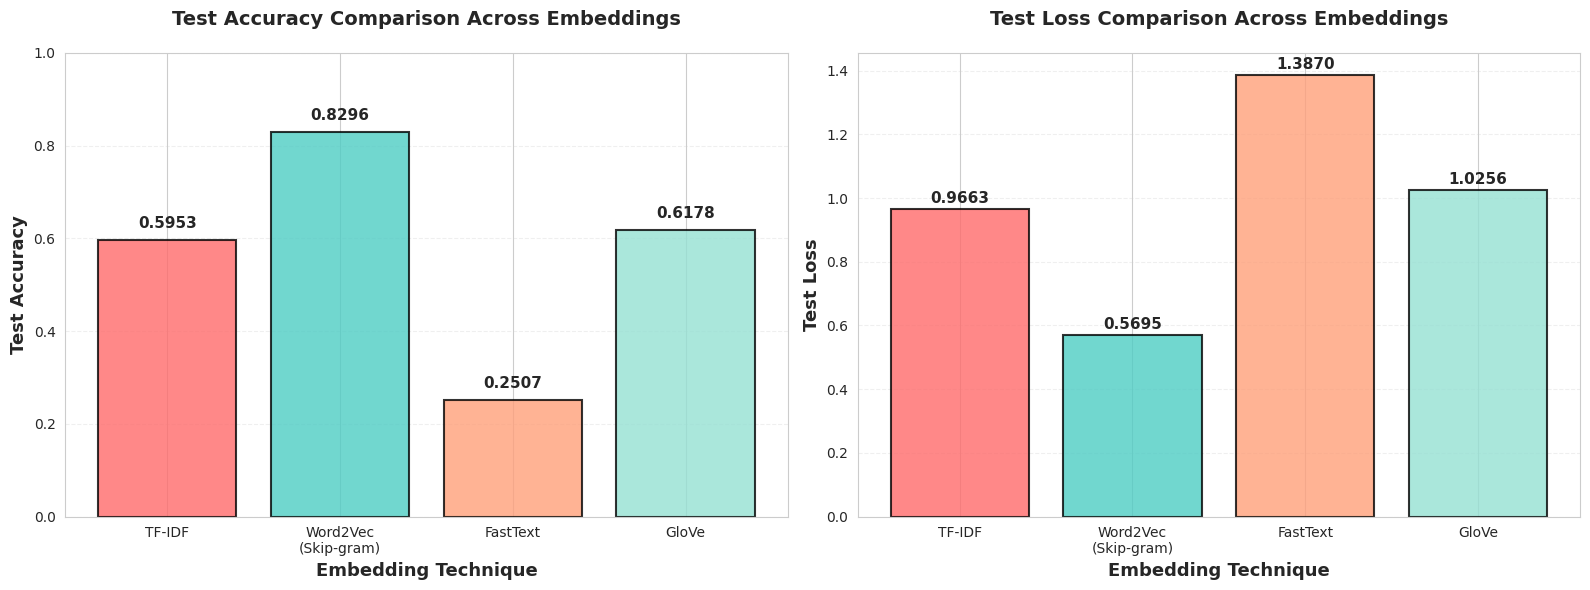


               WORD EMBEDDINGS COMPARISON SUMMARY
              Embedding  Test Accuracy  Test Loss
1  Word2Vec (Skip-gram)       0.829605   0.569524
2                 GloVe       0.617763   1.025612
3                TF-IDF       0.595263   0.966272
4              FastText       0.250658   1.387035

🏆 Best Accuracy: 0.8296 (Word2Vec (Skip-gram))
🏆 Lowest Loss: 0.5695 (Word2Vec (Skip-gram))


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')

# Prepare comparison data
embeddings = ['TF-IDF', 'Word2Vec\n(Skip-gram)', 'FastText', 'GloVe']
accuracies = [test_accuracy, test_accuracy_skip, test_accuracy_ft, test_accuracy_glove]
losses = [test_loss, test_loss_skip, test_loss_ft, test_loss_glove]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define colors
colors = ['#FF6B6B', '#4ECDC4', '#FFA07A', '#95E1D3']

# Plot 1: Test Accuracy Comparison
bars1 = axes[0].bar(embeddings, accuracies, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0].set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Embedding Technique', fontsize=13, fontweight='bold')
axes[0].set_title('Test Accuracy Comparison Across Embeddings', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, val in zip(bars1, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.02,
                f'{val:.4f}', ha='center', va='bottom',
                fontweight='bold', fontsize=11)

# Plot 2: Test Loss Comparison
bars2 = axes[1].bar(embeddings, losses, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
axes[1].set_ylabel('Test Loss', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Embedding Technique', fontsize=13, fontweight='bold')
axes[1].set_title('Test Loss Comparison Across Embeddings', fontsize=14, fontweight='bold', pad=20)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, val in zip(bars2, losses):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{val:.4f}', ha='center', va='bottom',
                fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print(" " * 15 + "WORD EMBEDDINGS COMPARISON SUMMARY")
print("="*70)
comparison_df = pd.DataFrame({
    'Embedding': ['TF-IDF', 'Word2Vec (Skip-gram)', 'FastText', 'GloVe'],
    'Test Accuracy': accuracies,
    'Test Loss': losses
})
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)
comparison_df.index = comparison_df.index + 1
print(comparison_df.to_string())
print("="*70)

best_acc_idx = accuracies.index(max(accuracies))
best_loss_idx = losses.index(min(losses))

print(f"\n🏆 Best Accuracy: {max(accuracies):.4f} ({embeddings[best_acc_idx].replace(chr(10), ' ')})")
print(f"🏆 Lowest Loss: {min(losses):.4f} ({embeddings[best_loss_idx].replace(chr(10), ' ')})")
print("="*70)
